# 1. Importing Required Libraries

In [20]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import xgboost as xgb
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import matplotlib.pyplot as plt

# 2. Helper Functions for Technical Indicators

## These functions compute the technical indicators (e.g., SMA, EMA, ATR, Bollinger Bands, MACD, RSI) used to generate trading signals.

In [21]:

def calculate_sma(df, period, column="close"):
    return df[column].rolling(window=period).mean()

def calculate_ema(df, period, column="close"):
    return df[column].ewm(span=period, adjust=False).mean()

def calculate_atr(df, period=14):
    high_low = df['high'] - df['low']
    high_close = np.abs(df['high'] - df['close'].shift())
    low_close = np.abs(df['low'] - df['close'].shift())
    true_range = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
    atr = true_range.rolling(window=period).mean()
    return atr

def calculate_bbands(df, period=20):
    sma = calculate_sma(df, period)
    stddev = df['close'].rolling(window=period).std()
    upper_band = sma + (2 * stddev)
    lower_band = sma - (2 * stddev)
    return pd.DataFrame({"BB_MIDDLE": sma, "BB_UPPER": upper_band, "BB_LOWER": lower_band})

def calculate_macd(df, fast_period=12, slow_period=26, signal_period=9):
    fast_ema = calculate_ema(df, fast_period)
    slow_ema = calculate_ema(df, slow_period)
    macd = fast_ema - slow_ema
    signal_line = macd.ewm(span=signal_period, adjust=False).mean()
    return pd.DataFrame({"MACD": macd, "SIGNAL_LINE": signal_line})

def calculate_rsi(df, period=14, column="close"):
    delta = df[column].diff(1)
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=period).mean()
    avg_loss = loss.rolling(window=period).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# 3. Scraping News Data from Forex Factory

## This part uses Selenium and BeautifulSoup to scrape economic news data from Forex Factory and store it as a DataFrame.

In [22]:

# 1. SCRAPING NEWS DATA FROM FOREX FACTORY
def get_forex_factory_news():
    # Set up Selenium WebDriver
    service = Service(ChromeDriverManager().install())
    driver = webdriver.Chrome(service=service)
    
    # Open Forex Factory
    driver.get("https://www.forexfactory.com/")
    
    # Wait for the page to load
    try:
        WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.CLASS_NAME, "calendar__row")))
    except Exception as e:
        print(f"Error loading page: {e}")
        driver.quit()
    
    # Get page source and parse with BeautifulSoup
    html = driver.page_source
    soup = BeautifulSoup(html, 'html.parser')
    
    # Scrape calendar rows
    news_data = []
    for row in soup.find_all('tr', class_='calendar__row'):
        event_time_elem = row.find('td', class_='calendar__time')
        currency_elem = row.find('td', class_='calendar__currency')
        impact_elem = row.find('td', class_='impact')
        event_title_elem = row.find('td', class_='calendar__event')
        forecast_elem = row.find('td', class_='calendar__forecast')
        actual_elem = row.find('td', class_='calendar__actual')
        
        # Extract text, if elements are not None
        event_time = event_time_elem.get_text().strip() if event_time_elem else None
        currency = currency_elem.get_text().strip() if currency_elem else None
        impact = impact_elem.get_text().strip() if impact_elem else None
        event_title = event_title_elem.get_text().strip() if event_title_elem else None
        forecast = forecast_elem.get_text().strip() if forecast_elem else None
        actual = actual_elem.get_text().strip() if actual_elem else None
        
        # Only append if essential fields are present
        if event_time and currency and event_title:
            news_data.append({
                "time": event_time,
                "currency": currency,
                "impact": impact,
                "event": event_title,
                "forecast": forecast,
                "actual": actual
            })
    
    # Close the browser
    driver.quit()
    
    # Return as DataFrame
    return pd.DataFrame(news_data)
# Fetch news data
news_df = get_forex_factory_news()

# 2. PROCESS NEWS DATA
# Convert 'time' to datetime, drop rows with invalid datetime entries
news_df['time'] = pd.to_datetime(news_df['time'], errors='coerce')
news_df.dropna(subset=['time'], inplace=True)  # Drop rows with invalid time
news_df.sort_values('time', inplace=True)

print(news_df.head())  # Check news data



                 time currency impact                         event forecast  \
0 2024-10-29 00:30:00      CAD   None        BOC Gov Macklem Speaks            
1 2024-10-29 05:30:00      AUD   None                       CPI q/q     0.3%   
2 2024-10-29 10:00:00      JPY   None           Consumer Confidence     36.7   
4 2024-10-29 11:30:00      EUR   None  French Consumer Spending m/m     0.1%   
5 2024-10-29 13:00:00      CHF   None        KOF Economic Barometer    105.1   

  actual  
0         
1   0.2%  
2         
4         
5         


C:\Users\Ali\AppData\Local\Temp\ipykernel_14516\2659296184.py:60: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  news_df['time'] = pd.to_datetime(news_df['time'], errors='coerce')


In [25]:
news_df

,time,currency,impact,event,forecast,actual
0,2024-10-29 00:30:00,CAD,None,BOC Gov Macklem Speaks,,
1,2024-10-29 05:30:00,AUD,None,CPI q/q,0.3%,0.2%
2,2024-10-29 10:00:00,JPY,None,Consumer Confidence,36.7,
4,2024-10-29 11:30:00,EUR,None,French Consumer Spending m/m,0.1%,
5,2024-10-29 13:00:00,CHF,None,KOF Economic Barometer,105.1,
6,2024-10-29 13:55:00,EUR,None,German Unemployment Change,15K,
7,2024-10-29 14:00:00,CHF,None,SNB Chairman Schlegel Speaks,,
8,2024-10-29 15:00:00,EUR,None,Prelim Flash GDP q/q,0.2%,
10,2024-10-29 17:15:00,USD,None,ADP Non-Farm Employment Change,110K,
11,2024-10-29 17:30:00,USD,None,Advance GDP q/q,3.0%,


In [26]:

# Load the dataset
signals_df = pd.read_csv("EURUSD.csv")

# Preprocessing the data
signals_df = signals_df[signals_df['volume'] != 0]
signals_df.reset_index(drop=True, inplace=True)

In [27]:
signals_df

,Gmt time,open,high,low,close,volume
0,04.05.2003 21:00:00.000,1.12354,1.12354,1.12166,1.12274,95533.0976
1,05.05.2003 01:00:00.000,1.12242,1.12276,1.12067,1.12126,93778.5996
2,05.05.2003 05:00:00.000,1.12139,1.12255,1.12030,1.12113,90924.6992
3,05.05.2003 09:00:00.000,1.12092,1.12331,1.12049,1.12174,91254.6992
4,05.05.2003 13:00:00.000,1.12194,1.12900,1.12130,1.12712,308003.4083
...,...,...,...,...,...,...
28821,15.10.2021 01:00:00.000,1.15940,1.16120,1.15938,1.16082,5738.6300
28822,15.10.2021 05:00:00.000,1.16082,1.16189,1.15995,1.16034,13149.6600
28823,15.10.2021 09:00:00.000,1.16033,1.16124,1.15892,1.15923,14914.3300
28824,15.10.2021 13:00:00.000,1.15923,1.16103,1.15893,1.15953,20002.5300


In [28]:
longest_MA_window = 200
signals_df["9EMA"] = calculate_ema(signals_df, 9).fillna(method='bfill')
signals_df["20EMA"] = calculate_ema(signals_df, 20).fillna(method='bfill')
signals_df["50EMA"] = calculate_ema(signals_df, 50).fillna(method='bfill')
signals_df["200SMA"] = calculate_sma(signals_df, longest_MA_window).fillna(method='bfill')

# Setup Indicators
signals_df["ATR"] = calculate_atr(signals_df).fillna(method='bfill')
bbands_df = calculate_bbands(signals_df)
macd_df = calculate_macd(signals_df)
signals_df["RSI"] = calculate_rsi(signals_df).fillna(method='bfill')

# Merge technical indicators
bbands_df = pd.concat([bbands_df, macd_df], axis=1)
signals_df = pd.concat([signals_df, bbands_df], axis=1)
signals_df.drop(columns="SIGNAL_LINE", inplace=True)

C:\Users\Ali\AppData\Local\Temp\ipykernel_14516\2872316713.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  signals_df["9EMA"] = calculate_ema(signals_df, 9).fillna(method='bfill')
C:\Users\Ali\AppData\Local\Temp\ipykernel_14516\2872316713.py:3: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  signals_df["20EMA"] = calculate_ema(signals_df, 20).fillna(method='bfill')
C:\Users\Ali\AppData\Local\Temp\ipykernel_14516\2872316713.py:4: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  signals_df["50EMA"] = calculate_ema(signals_df, 50).fillna(method='bfill')
C:\Users\Ali\AppData\Local\Temp\ipykernel_14516\2872316713.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or 

In [29]:
signals_df

,Gmt time,open,high,low,close,volume,9EMA,20EMA,50EMA,200SMA,ATR,RSI,BB_MIDDLE,BB_UPPER,BB_LOWER,MACD
0,04.05.2003 21:00:00.000,1.12354,1.12354,1.12166,1.12274,95533.0976,1.122740,1.122740,1.122740,1.165751,0.004187,85.382060,NaN,NaN,NaN,0.000000
1,05.05.2003 01:00:00.000,1.12242,1.12276,1.12067,1.12126,93778.5996,1.122444,1.122599,1.122682,1.165751,0.004187,85.382060,NaN,NaN,NaN,-0.000118
2,05.05.2003 05:00:00.000,1.12139,1.12255,1.12030,1.12113,90924.6992,1.122181,1.122459,1.122621,1.165751,0.004187,85.382060,NaN,NaN,NaN,-0.000220
3,05.05.2003 09:00:00.000,1.12092,1.12331,1.12049,1.12174,91254.6992,1.122093,1.122391,1.122587,1.165751,0.004187,85.382060,NaN,NaN,NaN,-0.000248
4,05.05.2003 13:00:00.000,1.12194,1.12900,1.12130,1.12712,308003.4083,1.123098,1.122841,1.122764,1.165751,0.004187,85.382060,NaN,NaN,NaN,0.000162
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28821,15.10.2021 01:00:00.000,1.15940,1.16120,1.15938,1.16082,5738.6300,1.159392,1.158202,1.158420,1.171291,0.002006,70.710850,1.157183,1.162864,1.151503,0.001032
28822,15.10.2021 05:00:00.000,1.16082,1.16189,1.15995,1.16034,13149.6600,1.159582,1.158405,1.158495,1.171191,0.002048,67.108168,1.157453,1.163198,1.151709,0.001065
28823,15.10.2021 09:00:00.000,1.16033,1.16124,1.15892,1.15923,14914.3300,1.159511,1.158484,1.158524,1.171079,0.002106,60.939227,1.157633,1.163363,1.151902,0.000990
28824,15.10.2021 13:00:00.000,1.15923,1.16103,1.15893,1.15953,20002.5300,1.159515,1.158583,1.158563,1.170966,0.002151,60.765816,1.157798,1.163548,1.152048,0.000944


In [30]:
# Create Bollinger Bands signals
signals_df["Bollinger_Bands_Below_Lower_BB"] = np.where(signals_df["close"] < signals_df["BB_LOWER"], 1, 0)
signals_df["Bollinger_Bands_Above_Upper_BB"] = np.where(signals_df["close"] > signals_df["BB_UPPER"], 1, 0)

# Generate the 9EMA/20EMA crossover signals
signals_df['9EMA_above_20EMA'] = np.where(signals_df['9EMA'] > signals_df['20EMA'], 1, 0)
signals_df['9EMA_cross_20EMA'] = signals_df['9EMA_above_20EMA'].diff().fillna(0)

# Generate the 50EMA/200SMA crossover signals
signals_df['50EMA_above_200SMA'] = np.where(signals_df['50EMA'] > signals_df['200SMA'], 1, 0)
signals_df['50EMA_cross_200SMA'] = signals_df['50EMA_above_200SMA'].diff().fillna(0)

# --------------- Integrating Support and Resistance Signals with Engulfing/Star Patterns ---

In [31]:

# Support and Resistance Functions
def support(df, l, n1, n2):
    for i in range(l - n1 + 1, l + 1):
        if df['low'][i] > df['low'][i - 1]:  
            return 0
    for i in range(l + 1, l + n2 + 1):
        if df['low'][i] < df['low'][i - 1]:  
            return 0
    return 1

def resistance(df, l, n1, n2):
    for i in range(l - n1 + 1, l + 1):
        if df['high'][i] < df['high'][i - 1]:
            return 0
    for i in range(l + 1, l + n2 + 1):
        if df['high'][i] > df['high'][i - 1]:
            return 0
    return 1

# Engulfing & Star Pattern Functions
def isEngulfing(row, open_, close_):
    bodydiffmin = 0.002
    bodydiff = abs(open_[row] - close_[row])
    prev_bodydiff = abs(open_[row - 1] - close_[row - 1])
    
    if bodydiff < 0.000001:
        bodydiff = 0.000001

    if bodydiff > bodydiffmin and prev_bodydiff > bodydiffmin and open_[row - 1] < close_[row - 1] and open_[row] > close_[row]:
        return 1  # Bearish Engulfing
    elif bodydiff > bodydiffmin and prev_bodydiff > bodydiffmin and open_[row - 1] > close_[row - 1] and open_[row] < close_[row]:
        return 2  # Bullish Engulfing
    return 0

def isStar(l, open_, close_, high, low):
    bodydiffmin = 0.0020
    bodydiff = abs(open_[l] - close_[l])
    highdiff = high[l] - max(open_[l], close_[l])
    lowdiff = min(open_[l], close_[l]) - low[l]
    
    if bodydiff < 0.000001:
        bodydiff = 0.000001
    
    ratio1 = highdiff / bodydiff
    ratio2 = lowdiff / bodydiff
    
    if ratio1 > 1 and lowdiff < 0.2 * highdiff and bodydiff > bodydiffmin:
        return 1  # Bearish Star
    elif ratio2 > 1 and highdiff < 0.2 * lowdiff and bodydiff > bodydiffmin:
        return 2  # Bullish Star
    return 0

# Signal Generation Function for Support/Resistance and Patterns
def generate_support_resistance_signals(df, n1=2, n2=2, backCandles=30, lim=150e-5):
    signal = [0] * len(df)
    open_ = df['open']
    close_ = df['close']
    high = df['high']
    low = df['low']
    
    for row in range(backCandles, len(df) - n2):
        ss = []  # Support levels
        rr = []  # Resistance levels
        for subrow in range(row - backCandles + n1, row + 1):
            if support(df, subrow, n1, n2):
                ss.append(low[subrow])
            if resistance(df, subrow, n1, n2):
                rr.append(high[subrow])

        # Generate signals based on Engulfing and Star patterns
        engulfing_pattern = isEngulfing(row, open_, close_)
        star_pattern = isStar(row, open_, close_, high, low)
        
        if ((engulfing_pattern == 1 or star_pattern == 1) and closeResistance(df, row, rr, lim)):
            signal[row] = 1  # Sell Signal
        elif ((engulfing_pattern == 2 or star_pattern == 2) and closeSupport(df, row, ss, lim)):
            signal[row] = 2  # Buy Signal
        else:
            signal[row] = 0  # No Signal
    
    df['Support_Resistance_Signal'] = signal
    return df

def closeResistance(df, l, levels, lim):
    if len(levels) == 0:
        return 0
    return abs(df['high'][l] - min(levels, key=lambda x: abs(x - df['high'][l]))) <= lim

def closeSupport(df, l, levels, lim):
    if len(levels) == 0:
        return 0
    return abs(df['low'][l] - min(levels, key=lambda x: abs(x - df['low'][l]))) <= lim

# Generate Support and Resistance Signals
signals_df = generate_support_resistance_signals(signals_df)

# Combine with existing signals
# Create a new combined signal column
signals_df['Combined_Signal'] = signals_df[['9EMA_cross_20EMA', '50EMA_cross_200SMA', 'Support_Resistance_Signal']].max(axis=1)

# Proceed with the rest of the logic (Exit signals, news data integration, model training, etc.)


In [32]:
signals_df

,Gmt time,open,high,low,close,volume,9EMA,20EMA,50EMA,200SMA,...,BB_LOWER,MACD,Bollinger_Bands_Below_Lower_BB,Bollinger_Bands_Above_Upper_BB,9EMA_above_20EMA,9EMA_cross_20EMA,50EMA_above_200SMA,50EMA_cross_200SMA,Support_Resistance_Signal,Combined_Signal
0,04.05.2003 21:00:00.000,1.12354,1.12354,1.12166,1.12274,95533.0976,1.122740,1.122740,1.122740,1.165751,...,NaN,0.000000,0,0,0,0.0,0,0.0,0,0.0
1,05.05.2003 01:00:00.000,1.12242,1.12276,1.12067,1.12126,93778.5996,1.122444,1.122599,1.122682,1.165751,...,NaN,-0.000118,0,0,0,0.0,0,0.0,0,0.0
2,05.05.2003 05:00:00.000,1.12139,1.12255,1.12030,1.12113,90924.6992,1.122181,1.122459,1.122621,1.165751,...,NaN,-0.000220,0,0,0,0.0,0,0.0,0,0.0
3,05.05.2003 09:00:00.000,1.12092,1.12331,1.12049,1.12174,91254.6992,1.122093,1.122391,1.122587,1.165751,...,NaN,-0.000248,0,0,0,0.0,0,0.0,0,0.0
4,05.05.2003 13:00:00.000,1.12194,1.12900,1.12130,1.12712,308003.4083,1.123098,1.122841,1.122764,1.165751,...,NaN,0.000162,0,0,1,1.0,0,0.0,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28821,15.10.2021 01:00:00.000,1.15940,1.16120,1.15938,1.16082,5738.6300,1.159392,1.158202,1.158420,1.171291,...,1.151503,0.001032,0,0,1,0.0,0,0.0,0,0.0
28822,15.10.2021 05:00:00.000,1.16082,1.16189,1.15995,1.16034,13149.6600,1.159582,1.158405,1.158495,1.171191,...,1.151709,0.001065,0,0,1,0.0,0,0.0,0,0.0
28823,15.10.2021 09:00:00.000,1.16033,1.16124,1.15892,1.15923,14914.3300,1.159511,1.158484,1.158524,1.171079,...,1.151902,0.000990,0,0,1,0.0,0,0.0,0,0.0
28824,15.10.2021 13:00:00.000,1.15923,1.16103,1.15893,1.15953,20002.5300,1.159515,1.158583,1.158563,1.170966,...,1.152048,0.000944,0,0,1,0.0,0,0.0,0,0.0


In [33]:

# Initialize "Exit" and "Exit Price" columns
signals_df["Exit Price"] = np.nan
signals_df["Exit"] = np.nan

# Exit signal (target labels for ML)
num_rows_in_df = signals_df.shape[0]
reward = 3
risk = 1

# Loop through and calculate exit price and signals
for j in range(longest_MA_window, num_rows_in_df):
    entry = signals_df["close"].iloc[j]
    atr = signals_df["ATR"].iloc[j]
    stop = entry - (risk * atr)
    target = entry + (reward * atr)
    for k in range(j + 1, num_rows_in_df):
        curr_low = signals_df["low"].iloc[k]
        curr_high = signals_df["high"].iloc[k]
        if curr_low <= stop:
            signals_df.at[j, "Exit Price"] = stop
            signals_df.at[j, "Exit"] = -1
            break
        elif curr_high >= target:
            signals_df.at[j, "Exit Price"] = target
            signals_df.at[j, "Exit"] = 1
            break

# Drop rows that contain NaN values (from earlier calculations)
signals_df = signals_df.dropna(subset=["Exit"])

# Map Exit values from [-1, 1] to [0, 1]
signals_df["Exit"] = signals_df["Exit"].map({-1: 0, 1: 1})

C:\Users\Ali\AppData\Local\Temp\ipykernel_14516\1781248569.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  signals_df["Exit"] = signals_df["Exit"].map({-1: 0, 1: 1})


In [36]:
# Fetch news data
news_df = get_forex_factory_news()

# 2. PROCESS NEWS DATA
# Convert 'time' to datetime, drop rows with invalid datetime entries
news_df['time'] = pd.to_datetime(news_df['time'], errors='coerce')
news_df.dropna(subset=['time'], inplace=True)  # Drop rows with invalid time
news_df.sort_values('time', inplace=True)

# Merge news data with market data
signals_df["Gmt time"] = pd.to_datetime(signals_df["Gmt time"])
combined_df = pd.merge_asof(signals_df, news_df, left_on='Gmt time', right_on='time', direction='backward')

# Fill missing news fields with "No Data"
combined_df.fillna("No Data", inplace=True)

# Converting impact (categorical) to numeric codes for model training
combined_df['impact'] = combined_df['impact'].astype('category').cat.codes

C:\Users\Ali\AppData\Local\Temp\ipykernel_14516\2536662267.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  news_df['time'] = pd.to_datetime(news_df['time'], errors='coerce')
C:\Users\Ali\AppData\Local\Temp\ipykernel_14516\2536662267.py:11: UserWarning: Parsing dates in %d.%m.%Y %H:%M:%S.%f format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  signals_df["Gmt time"] = pd.to_datetime(signals_df["Gmt time"])
C:\Users\Ali\AppData\Local\Temp\ipykernel_14516\2536662267.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  signals_df["Gmt time"

C:\Users\Ali\AppData\Local\Temp\ipykernel_14516\1822632322.py:7: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df_model.hist(ax=ax)


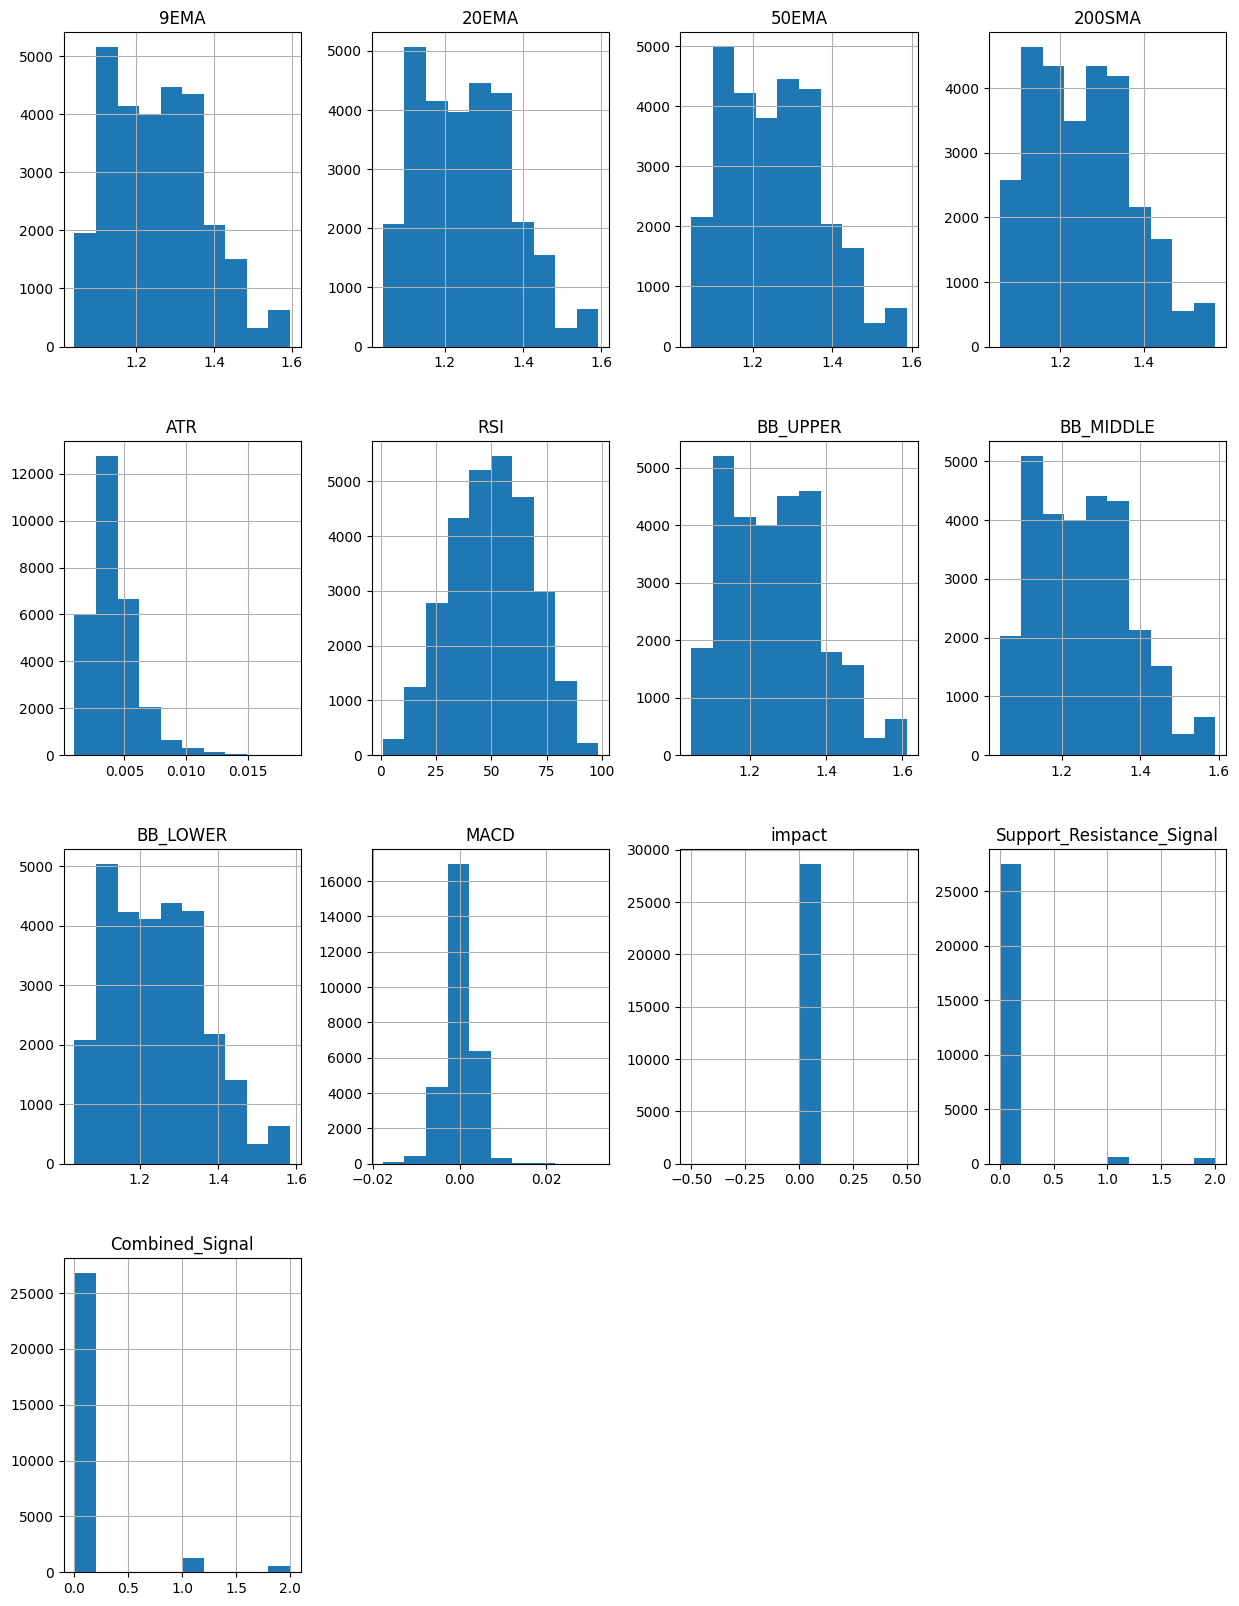

In [37]:
import matplotlib.pyplot as plt

# Plot histograms
fig = plt.figure(figsize=(15, 20))
ax = fig.gca()
df_model =X = combined_df[['9EMA', '20EMA', '50EMA', '200SMA', 'ATR', 'RSI', 'BB_UPPER', 'BB_MIDDLE', 'BB_LOWER', 'MACD', 'impact', 'Support_Resistance_Signal', 'Combined_Signal']]
df_model.hist(ax=ax)
plt.show()


In [46]:
# Selecting features and target, adding Support/Resistance and Patterns to feature set
X = combined_df[['9EMA', '20EMA', '50EMA', '200SMA', 'ATR', 'RSI', 'BB_UPPER', 'BB_MIDDLE', 'BB_LOWER', 'MACD', 'impact', 'Support_Resistance_Signal', 'Combined_Signal','Bollinger_Bands_Below_Lower_BB','Bollinger_Bands_Above_Upper_BB','9EMA_above_20EMA','9EMA_cross_20EMA','50EMA_above_200SMA','50EMA_cross_200SMA']]
y = combined_df['Exit']
print(X)


           9EMA     20EMA     50EMA    200SMA       ATR        RSI  BB_UPPER  \
0      1.169305  1.173985  1.175750  1.165946  0.004729  18.036319  1.194920   
1      1.168640  1.173223  1.175367  1.166170  0.005004  23.608721  1.194041   
2      1.168522  1.172730  1.175080  1.166404  0.005200  28.762915  1.191732   
3      1.169224  1.172663  1.174960  1.166656  0.005159  40.407470  1.190049   
4      1.169531  1.172482  1.174795  1.166874  0.004977  35.312862  1.188837   
...         ...       ...       ...       ...       ...        ...       ...   
28609  1.154718  1.155463  1.157979  1.172457  0.001756  38.146341  1.158427   
28610  1.154904  1.155481  1.157888  1.172362  0.001761  41.210375  1.158415   
28611  1.154783  1.155368  1.157747  1.172252  0.001901  37.175043  1.158432   
28612  1.158227  1.157086  1.158091  1.171785  0.002006  68.625277  1.160989   
28613  1.158712  1.157426  1.158191  1.171687  0.002104  63.631407  1.161533   

       BB_MIDDLE  BB_LOWER      MACD  i

In [47]:

# Selecting features and target, adding Support/Resistance and Patterns to feature set
X = combined_df[['9EMA', '20EMA', '50EMA', '200SMA', 'ATR', 'RSI', 'BB_UPPER', 'BB_MIDDLE', 'BB_LOWER', 'MACD', 'impact', 'Support_Resistance_Signal', 'Combined_Signal','Bollinger_Bands_Below_Lower_BB','Bollinger_Bands_Above_Upper_BB','9EMA_above_20EMA','9EMA_cross_20EMA','50EMA_above_200SMA','50EMA_cross_200SMA']]
y = combined_df['Exit']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# XGBoost Model
xgb_model = xgb.XGBClassifier()
xgb_model.fit(X_train, y_train)

# Predictions
y_train_pred = xgb_model.predict(X_train)
y_test_pred = xgb_model.predict(X_test)

train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f'Training Accuracy: {train_accuracy * 100:.2f}%')
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

# 1. Classification reports for training and test sets
print("Classification Report for Training Data:")
print(classification_report(y_train, y_train_pred))

print("\nClassification Report for Test Data:")
print(classification_report(y_test, y_test_pred))



Training Accuracy: 87.17%
Test Accuracy: 80.90%
Classification Report for Training Data:
              precision    recall  f1-score   support

           0       0.86      0.99      0.92     16962
           1       0.94      0.54      0.69      5929

    accuracy                           0.87     22891
   macro avg       0.90      0.76      0.80     22891
weighted avg       0.88      0.87      0.86     22891


Classification Report for Test Data:
              precision    recall  f1-score   support

           0       0.82      0.96      0.88      4313
           1       0.74      0.34      0.47      1410

    accuracy                           0.81      5723
   macro avg       0.78      0.65      0.68      5723
weighted avg       0.80      0.81      0.78      5723



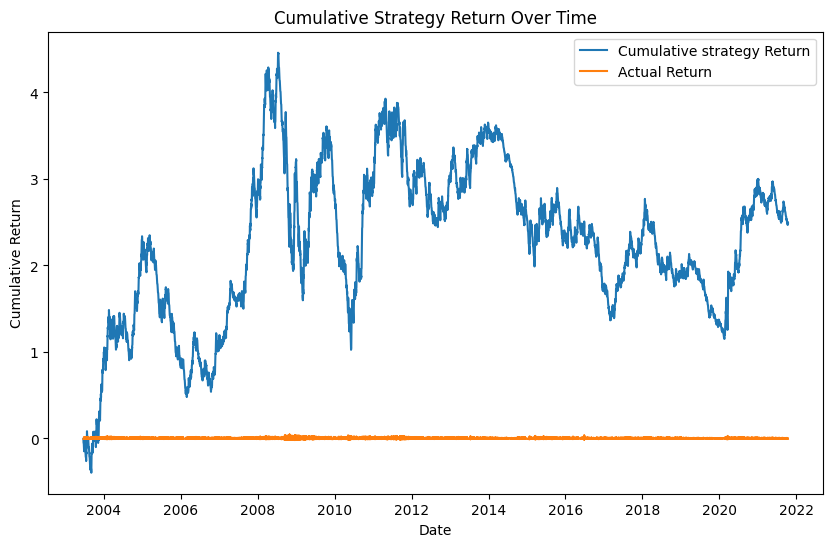

In [48]:


# 2. Calculate actual returns for each trade
def calculate_actual_return(row):
    if row["Exit"] == 1:  # Target hit (win)
        return row["Exit Price"] - row["close"]  # Profit: Exit price - entry price
    elif row["Exit"] == 0:  # Stop hit (loss)
        return row["Exit Price"] - row["close"]  # Loss: Exit price - entry price
    return 0

combined_df["Actual Return"] = combined_df.apply(calculate_actual_return, axis=1)

# 3. Calculate cumulative returns
combined_df["Cumulative strategy Return"] = combined_df["Actual Return"].cumsum()

# Output the cumulative return over the entire dataset

# Visualize the cumulative returns over time
plt.figure(figsize=(10, 6))
plt.plot(combined_df['Gmt time'], combined_df['Cumulative strategy Return'], label='Cumulative strategy Return')
plt.plot(combined_df['Gmt time'], combined_df['Actual Return'], label='Actual Return')

plt.title('Cumulative Strategy Return Over Time')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.show()

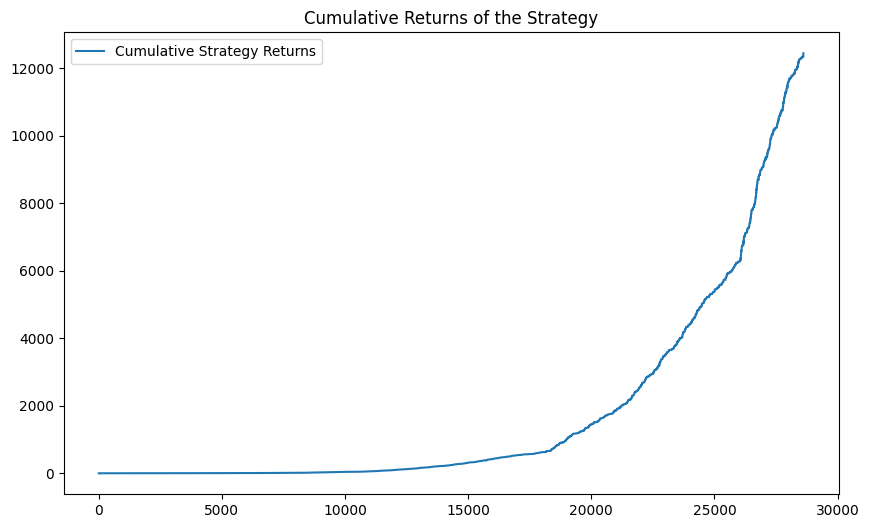

In [52]:
# Calculate cumulative returns based on the signals
combined_df['Strategy_Returns'] = combined_df['Exit'].shift(1) * combined_df['close'].pct_change()
combined_df['Cumulative_Strategy_Returns'] = (1 + combined_df['Strategy_Returns']).cumprod()
combined_df["Actual Return"] = combined_df.apply(calculate_actual_return, axis=1)


# Plot cumulative returns
plt.figure(figsize=(10, 6))
plt.plot(combined_df.index, combined_df['Cumulative_Strategy_Returns'], label='Cumulative Strategy Returns')
plt.title('Cumulative Returns of the Strategy')
plt.legend()
plt.show()